### Hello There!
Below is the code for the detection and characterization of benzodiazepine use.

This file includes some of the preprocessing, reshaping, as well as spatial-temporal modeling and cross validation code.

edit 1 Dec 22: fixed saving y_pred_test and y_pred_val

## K-Fold CV Stacked Conv-LSTM Model

# Set up and Installation

Import Libraries

In [ ]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

# Import Layers
from keras.layers import ConvLSTM2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling3D

Seed

In [ ]:
# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

TPU configuration: Ensure that you are connected to a TPU.

In [ ]:
# @title TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# ----------
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)

print("c device: ", c.device)
print(c)
# ----------

strategy = tf.distribute.TPUStrategy(resolver)

# ----------
@tf.function
def matmul_fn(x, y):
  z = tf.matmul(x, y)
  return z

z = strategy.run(matmul_fn, args=(a, b))
print(z)

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data. Please ensure you are mounted to Google Drive

In [ ]:
# Load Data X
Wide_X = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/[Smooth]SEQN_WideX.parquet')
SEQN = Wide_X['SEQN']
Wide_X = Wide_X.drop(columns=['SEQN'])

In [ ]:
# Process X --------
data_wide = Wide_X

# Standard Scalar
scaler = StandardScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

In [ ]:
# Load Data Y
Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/new_benzo_y.csv')

In [ ]:
# Process Y --------
# Drop Unnamed Column
Y = Y.drop("Unnamed: 0", axis = 1)
Y.head()

# Change to Y Float
Y['Benzo'] = Y['y'].apply(lambda x: float(x))

#Make y array as well
y = np.hstack(np.asarray(Y.Benzo)).reshape(len(Y),1)

In [ ]:
# Shape Analysis
print("shape of X:", data_wide.shape)
print("shape of y:", y.shape)

shape of X: (7162, 10080)
shape of y: (7162, 1)


In [ ]:
# Class Analysis
benzoUse = int(sum(y))
total = int(len(y))
benzoNoUse = int(total-benzoUse)

print("Benzo Use:", benzoUse, "participants")
print("Benzo No Use:", benzoNoUse, "participants")

Benzo Use: 137 participants
Benzo No Use: 7025 participants


In [ ]:
# Demographic data

demo1 = np.load('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/X1_AgeSex.npy')
demo2= np.load('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/X2_Race.npy')
demo = np.concatenate((demo1,demo2), axis=1)
demo.shape

# Depression data
depDat = pd.read_sas('/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Data/DPQ_D.XPT')
depDat = depDat.round(1)
depSeqns = list(depDat['SEQN'])
depDat = depDat.drop(columns=['SEQN'])
depDat[depDat > 4] = 0
depDat = depDat.fillna(0) # take out dummy coding
depDat = depDat.drop(columns=['DPQ100'])
depDat['PHQ9'] = depDat.sum(axis=1)
print(depSeqns)
depDat

# add NaN to those without depression data

SD = pd.DataFrame(SEQN)

SD['PHQ9'] = np.nan

start = 0
for i in range(len(SD)):
  print(round(i/len(SD)*100,2), "%")
  for j in range(start, len(depSeqns)):
    if SD['SEQN'][i] == depSeqns[j]: # found match
      SD['PHQ9'][i] = depDat['PHQ9'][j]
      start+=1
  clear_output()

,SEQN,PHQ9
0,31128.0,NaN
1,31129.0,NaN
2,31131.0,0.0
3,31132.0,0.0
4,31133.0,NaN
...,...,...
7157,41469.0,2.0
7158,41471.0,NaN
7159,41472.0,0.0
7160,41473.0,4.0


In [ ]:
phq9 = np.array(list(SD['PHQ9'])).reshape(len(SD['PHQ9']),1)

Create a held out test set

In [ ]:
# Train Test Split (keep random state in check)
X_train, X_test, y_train, y_test, demo_train, demo_test, phq9_train, phq9_test = train_test_split(data_wide, y, demo, phq9, test_size=0.2, stratify=y, random_state = 19) # Hard coded random seed

# Dimentions
n_steps, n_length, n_width = 7, 24, 60
n_features = 1

# Reshape Train and Test
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_width, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_width, n_features))

Graphical Analysis

day: 1


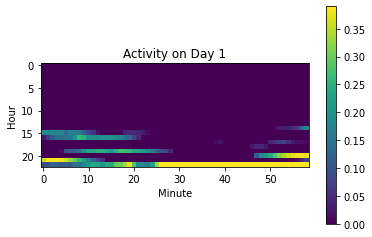

day: 2


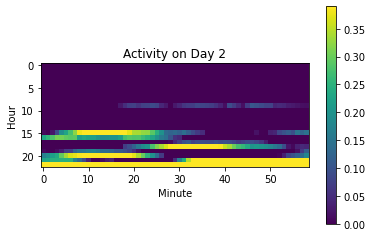

day: 3


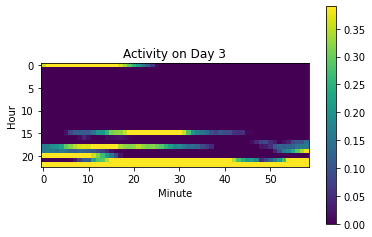

day: 4


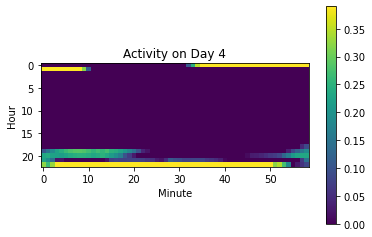

day: 5


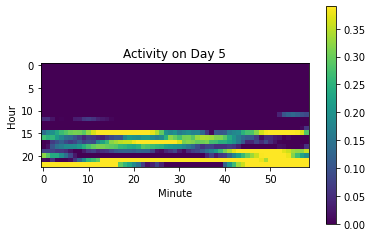

day: 6


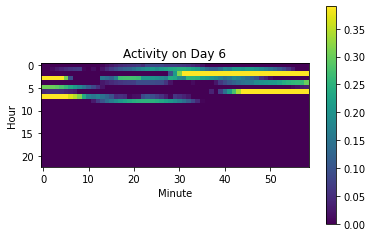

day: 7


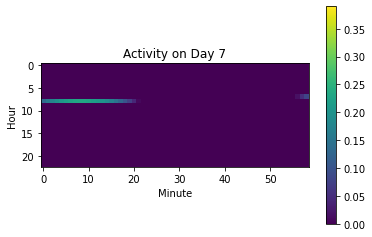

In [ ]:
for day in range(0,7):
  sli = X_train[11, day, 0:23, 0:59, 0]
  print("day:", day + 1)
  plt.imshow(sli, interpolation='none', vmin=0, vmax=.39)
  plt.colorbar(orientation='vertical')
  plt.title("Activity on Day " + str(day+1))
  plt.xlabel("Minute")
  plt.ylabel("Hour")
  plt.show()

# Model Architecture

Import certain files from Keras

In [ ]:
# Model Structure
def create_model():
  model = Sequential()

  # Conv Layers
  model.add(ConvLSTM2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(n_steps, n_length, n_width, n_features) ,return_sequences=True) )
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(ConvLSTM2D(filters=64, kernel_size=(2, 2), padding='valid', return_sequences= False))

  # Feed Forward Layers
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #Sigmoid b/c our outcome is binary.

  return model

# Model Compilation & Fitting

In [ ]:
# Compile the model -----
with strategy.scope():
  # Create the model we defined above
  model = create_model()
  # Compile
  model.compile(
    # Metrics
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= tf.keras.metrics.AUC(name='auc'),
    # Optimizer
    optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
    )
)

model.summary()
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/base_model_weights.h5")

def reset_model():
  model.load_weights("/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/base_model_weights.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 7, 20, 56, 32)     105728    
                                                                 
 activation_1 (Activation)   (None, 7, 20, 56, 32)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 10, 28, 32)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 9, 27, 64)         98560     
                                                                 
 dropout_2 (Dropout)         (None, 9, 27, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 15552)             0         
                                                      

Set Parameters

In [ ]:
# Params ----------
# Balance Weights
class_weights = {0: (benzoUse/total),  # Custom Setting Class Weights
                1: (benzoNoUse/total)}

# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                            patience=90,
                                            restore_best_weights=True,
                                            )

Fit the model

In [ ]:
# Fit the Model
histories = []
def fit_model(X_training, y_training, X_val, y_val):
  history = model.fit(
      X_training, y_training,
      epochs= 250,
      batch_size= 64,
      validation_data = (X_val, y_val),
      shuffle=False,
      class_weight=class_weights,
      callbacks = [callback],
      verbose = 2
  )
  histories.append(history)

In [ ]:
# Save the model
def save_model(count):
  model.save("/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/full_model_" + str(count) + ".h5")
  model.save_weights("/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/weights_" + str(count) +".hdf5")

In [ ]:
# Model Evaluation
def model_eval():
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\ntest set:")
  scores = model.evaluate(X_test, y_test, batch_size=64) # Test Set
  cv_test_scores.append(scores[1])
  y_pred_test = model.predict(X_test)


  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\nval set:")
  scores = model.evaluate(X_val, y_val, batch_size=64)  # Validation Set
  cv_val_scores.append(scores[1])
  y_pred_val = model.predict(X_val)

  return y_pred_test, y_pred_val

  #Return predictions

In [ ]:
# Save all predictions and file
def save_files(count):
  # Preds
  pred_filepath = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/Prediction Files"
  np.save(pred_filepath + "/y_pred_test_" + str(count) + ".npy", y_pred_test, allow_pickle=True)
  np.save(pred_filepath + "/y_pred_val_" + str(count) + ".npy", y_pred_val, allow_pickle=True)

  # Train
  train_filepath = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/Training Files"
  np.save(train_filepath + "/X_train_" + str(count) + ".npy", X_training, allow_pickle=True)
  np.save(train_filepath + "/y_train_" + str(count) + ".npy", y_training, allow_pickle=True)

  # Test
  test_filepath = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/Testing Files"
  np.save(test_filepath + "/X_test_" + str(count) + ".npy", X_test, allow_pickle=True)
  np.save(test_filepath + "/y_test_" + str(count) + ".npy", y_test, allow_pickle=True)

  # Validation
  val_filepath = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/Validation Files"
  np.save(val_filepath + "/X_val_" + str(count) + ".npy", X_val, allow_pickle=True)
  np.save(val_filepath + "/y_val_" + str(count) + ".npy", y_val, allow_pickle=True)

  # LR_train (contains training data for LR analysis)
  lr_train = np.concatenate((y_pred_test, demo_test), axis=1)
  lr_train = np.concatenate((lr_train, phq9_test), axis=1)
  lr_filepath = "/content/drive/MyDrive/Colab Notebooks/Benzos Classification/Model Weights/lr_train"
  np.save(lr_filepath + "/lr_train" + str(count) + ".npy", lr_train, allow_pickle=True)



# 10-Fold Cross Validation

In [ ]:
#@title K-Fold CV Model
%%time
from sklearn.model_selection import StratifiedKFold

# Global Score List Buckets
cv_test_scores=[]
cv_val_scores=[]

# K fold parameters
seed = 2
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# run K-fold
count = 1
for train, val in kfold.split(X_train, y_train):

  # Create New Training Set
  X_training = X_train[train]
  y_training = y_train[train]
  # Create new Validation Sets
  X_val = X_train[val]
  y_val = y_train[val]

  # Reset model
  print("Resetting model..")
  reset_model()
  # Fit model
  fit_model(X_training, y_training, X_val, y_val)
  # Eval model
  y_pred_test, y_pred_val = model_eval()
  # Save model
  print("Saving model...")
  save_model(count)
  # Save files
  print("Saving files...")
  save_files(count)

  # increment
  print("FINISHED CYCLE NUMBER:", count)
  count += 1

# Score Eval
print("\nCV Test AUC----------------------------")
print("Individual scores:", cv_test_scores)
print("Mean:", np.mean(cv_test_scores))
print("std:", np.std(cv_test_scores))
print("\nCV Val AUC-----------------------------")
print("Individual scores:", cv_val_scores)
print("Mean:", np.mean(cv_val_scores))
print("std:", np.std(cv_val_scores))

Resetting model..
Epoch 1/250
81/81 - 7s - loss: 0.0257 - auc: 0.6420 - val_loss: 0.6068 - val_auc: 0.8267 - 7s/epoch - 91ms/step
Epoch 2/250
81/81 - 7s - loss: 0.0251 - auc: 0.6897 - val_loss: 0.5511 - val_auc: 0.8282 - 7s/epoch - 87ms/step
Epoch 3/250
81/81 - 7s - loss: 0.0246 - auc: 0.6926 - val_loss: 0.5428 - val_auc: 0.8184 - 7s/epoch - 87ms/step
Epoch 4/250
81/81 - 7s - loss: 0.0241 - auc: 0.6956 - val_loss: 0.5652 - val_auc: 0.8186 - 7s/epoch - 86ms/step
Epoch 5/250
81/81 - 7s - loss: 0.0238 - auc: 0.6929 - val_loss: 0.5918 - val_auc: 0.8111 - 7s/epoch - 87ms/step
Epoch 6/250
81/81 - 7s - loss: 0.0235 - auc: 0.6957 - val_loss: 0.6075 - val_auc: 0.8123 - 7s/epoch - 87ms/step
Epoch 7/250
81/81 - 7s - loss: 0.0233 - auc: 0.6992 - val_loss: 0.6104 - val_auc: 0.8174 - 7s/epoch - 88ms/step
Epoch 8/250
81/81 - 7s - loss: 0.0231 - auc: 0.7056 - val_loss: 0.6128 - val_auc: 0.8206 - 7s/epoch - 88ms/step
Epoch 9/250
81/81 - 7s - loss: 0.0230 - auc: 0.7104 - val_loss: 0.6099 - val_auc: 0.82

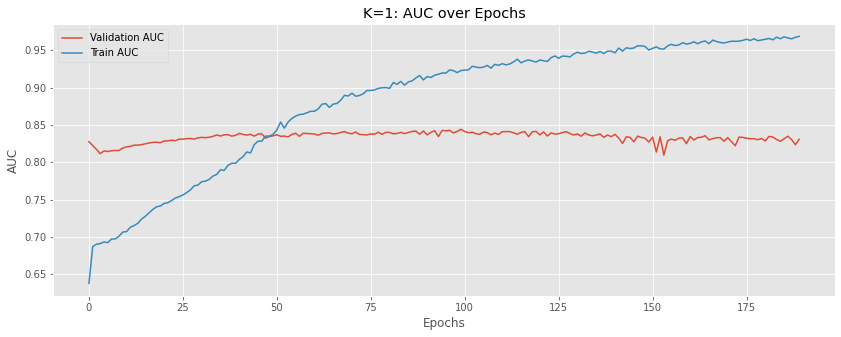

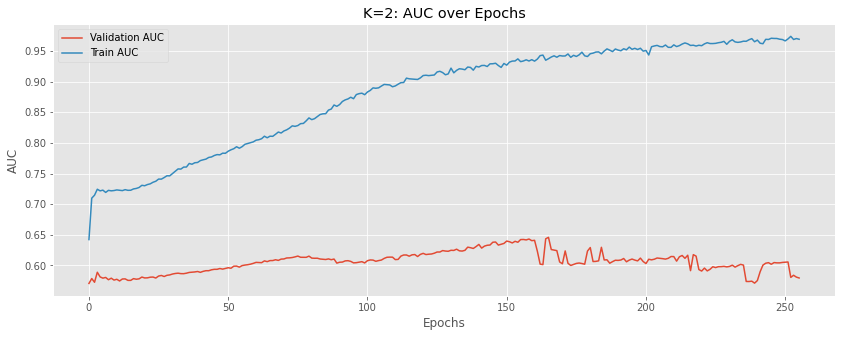

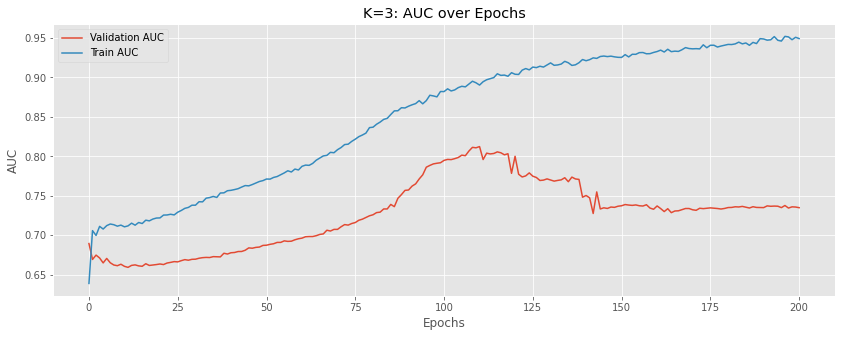

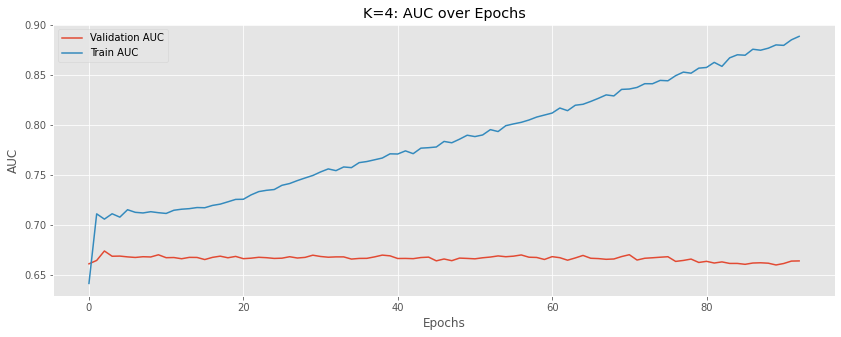

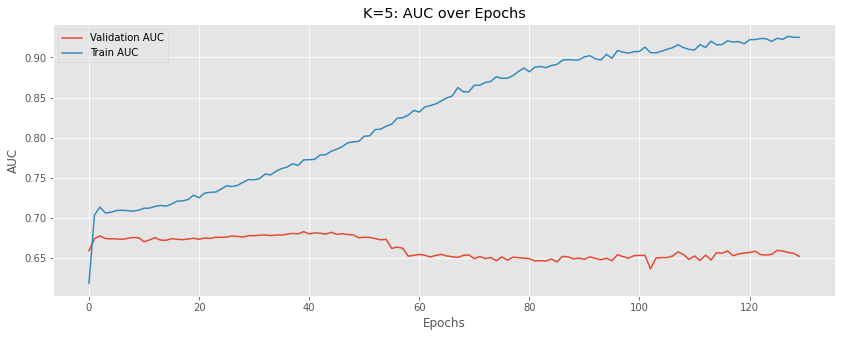

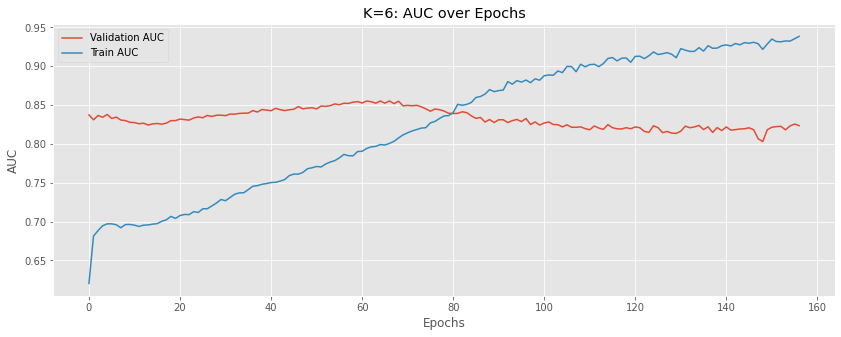

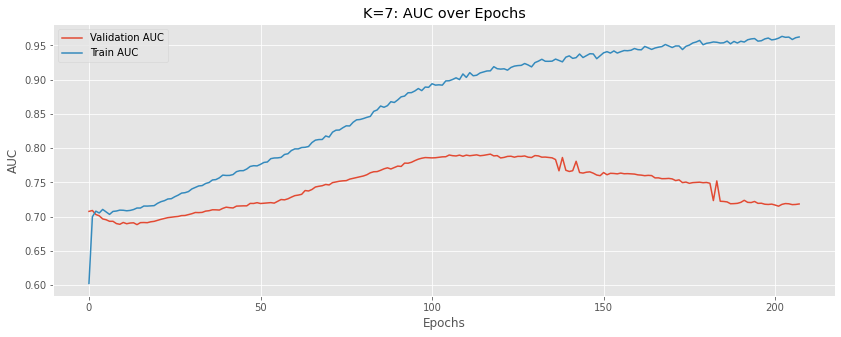

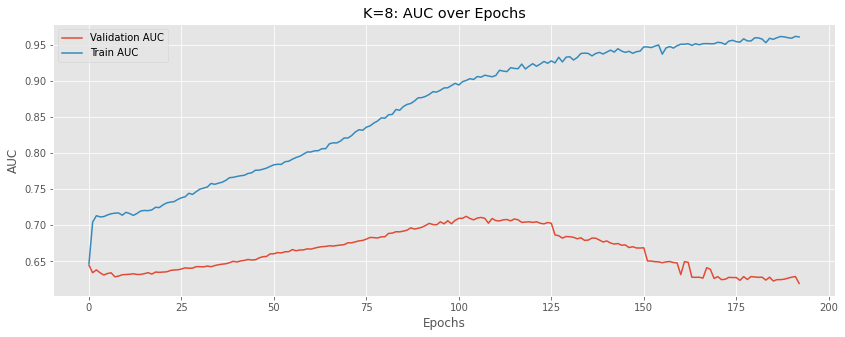

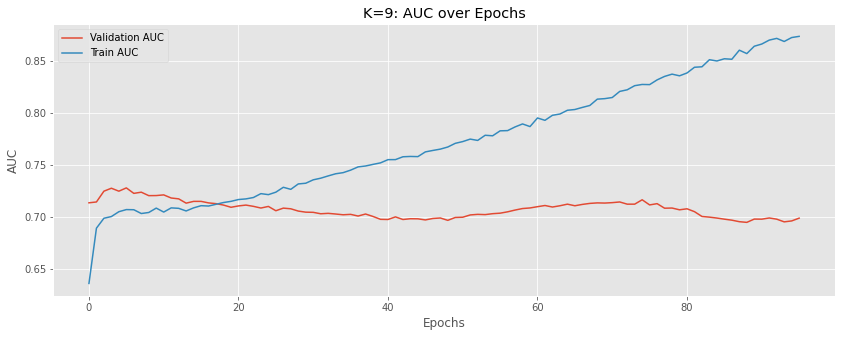

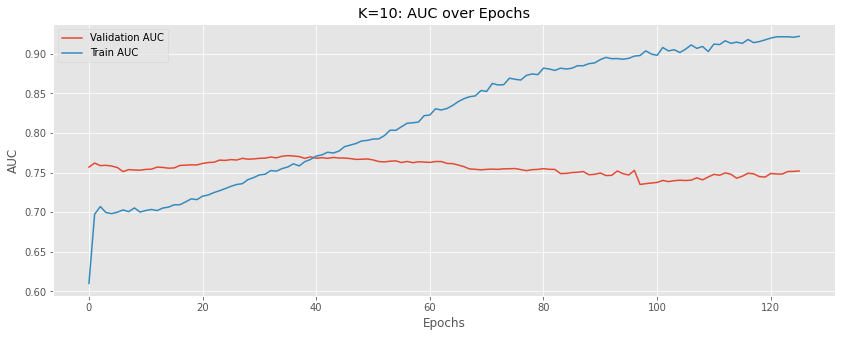

In [ ]:
# Style Sheet
plt.style.use('ggplot')

# Plot AUC and Loss
count = 1
for history in histories:
  plt.figure(figsize=(14,5))
  plt.title("K=" + str(count) + ": AUC over Epochs")
  plt.ylabel("AUC")
  plt.xlabel("Epochs")
  plt.plot(history.history['val_auc'], label='Validation AUC')
  plt.plot(history.history['auc'], label='Train AUC')
  plt.legend()

  # plt.figure(figsize=(15,7))
  # plt.title("LOSS over Epochs")
  # plt.ylabel("Loss")
  # plt.xlabel("Epochs")
  # plt.plot(history.history['val_loss'], label='Validation Loss')
  # plt.plot(history.history['loss'], label='Train Loss')
  # plt.legend()

  count+=1

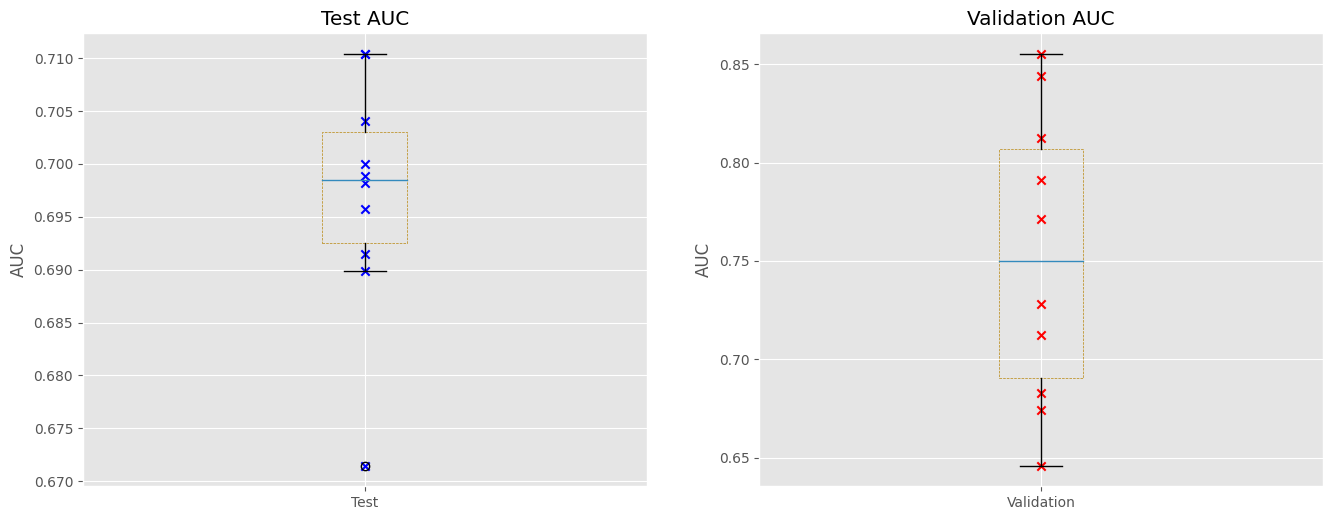

In [ ]:
fig = plt.figure(figsize=(16,6), dpi=100)

plt.subplot(1,2,1)
plt.title("Test AUC")
plt.ylabel("AUC")
boxprops = dict(linestyle='--', linewidth=.5, color='darkgoldenrod')
plt.boxplot([cv_test_scores], boxprops=boxprops)
clear_output()
plt.xticks([1], ['Test'])

# Test
for value in (cv_test_scores):
  plt.scatter(1, value, marker='x', c='blue')

# Validation
plt.subplot(1,2,2)
plt.title("Validation AUC")
plt.ylabel("AUC")
boxprops = dict(linestyle='--', linewidth=.5, color='darkgoldenrod')
plt.boxplot([cv_val_scores], boxprops=boxprops)
clear_output()
plt.xticks([1], ['Validation'])

# Val
for value in (cv_val_scores):
  plt.scatter(1, value, marker='x', c='red')



*CV Performance is at the bottom of the cell above